In [1]:
import librosa
import os
import numpy as np

In [2]:
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

audio_files = {}

for g in genres:
  audio_files[g] = []

In [3]:
# Itérer sur les fichiers audio dans le répertoire pour le genre actuel
for g in genres:
  for audio in os.listdir(f'./Data/genres_original/{g}'):
    audio_files[g].append(librosa.core.load(f'./Data/genres_original/{g}/{audio}'))

In [4]:
mel_specs = []

for g in genres:

  for audio in audio_files[g]:

    y = audio[0]
    sr = audio[1]

    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
        
# On modifie la taille des images 128 x 660 en gardant les paramètres proposés dans l'article initial
    if spect.shape[1] != 600:
      # spect.resize(128,660, refcheck=False)
      spect = spect[:128,:600]
      # print(spect.shape)
      spect.reshape(128,600)

    mel_specs.append(spect)
        
X = np.array(mel_specs)

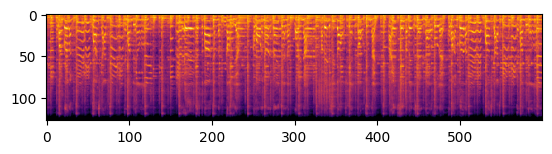

In [5]:
import matplotlib.pyplot as plt

plt.imshow(mel_specs[0], cmap="inferno")

In [6]:
y_cnn = []

for i in range(len(genres)):
  y_cnn +=100*[i] # On a 100 images pour chaque genre
y_cnn = np.array(y_cnn)

In [7]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split # Split de dataset et optimisation des hyperparamètres

# On split ensuite nos données en données de test et données d'entraînements :
y_cnn = to_categorical(y_cnn)
x_cnn_train, x_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X, y_cnn)

In [8]:
# On pense à normaliser les données, c'est important pour l'analyse d'images :
x_cnn_train /= -80
x_cnn_test /= -80

In [9]:
# A présent on met en forme nos données pour l'entraînement :
x_cnn_train = x_cnn_train.reshape(x_cnn_train.shape[0], 128, 600, 1)
x_cnn_test = x_cnn_test.reshape(x_cnn_test.shape[0], 128, 600, 1)

In [10]:
print(x_cnn_train.shape)
print(y_cnn_train.shape)

(750, 128, 600, 1)
(750, 10)


In [11]:
import tensorflow as tf
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(128,600,1)))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Conv2D(32, 
                 kernel_size=(3, 3), 
                 activation='relu'))

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(32, activation='relu'))

model.add(tf.keras.layers.Dense(10, activation='softmax'))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 598, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 299, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 297, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 148, 64)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 30, 148, 64)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 146, 32)       1

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [14]:
history = model.fit(x_cnn_train,
                    y_cnn_train,
                    epochs=50,
                    batch_size=64,
                    validation_data = (x_cnn_test,y_cnn_test))

Epoch 1/50
12/12 [==============================] - 53s 4s/step - loss: 2.3163 - accuracy: 0.0840 - val_loss: 2.3029 - val_accuracy: 0.0840
Epoch 2/50
12/12 [==============================] - 26s 2s/step - loss: 2.2992 - accuracy: 0.1027 - val_loss: 2.3018 - val_accuracy: 0.1120
Epoch 3/50
12/12 [==============================] - 26s 2s/step - loss: 2.2955 - accuracy: 0.1200 - val_loss: 2.3027 - val_accuracy: 0.0760
Epoch 4/50
12/12 [==============================] - 26s 2s/step - loss: 2.2917 - accuracy: 0.1080 - val_loss: 2.3016 - val_accuracy: 0.0760
Epoch 5/50
12/12 [==============================] - 26s 2s/step - loss: 2.2892 - accuracy: 0.1307 - val_loss: 2.2987 - val_accuracy: 0.1440
Epoch 6/50
12/12 [==============================] - 29s 2s/step - loss: 2.2876 - accuracy: 0.1507 - val_loss: 2.2975 - val_accuracy: 0.0760
Epoch 7/50
12/12 [==============================] - 30s 3s/step - loss: 2.2887 - accuracy: 0.1080 - val_loss: 2.2943 - val_accuracy: 0.1560
Epoch 8/50
12/12 [==

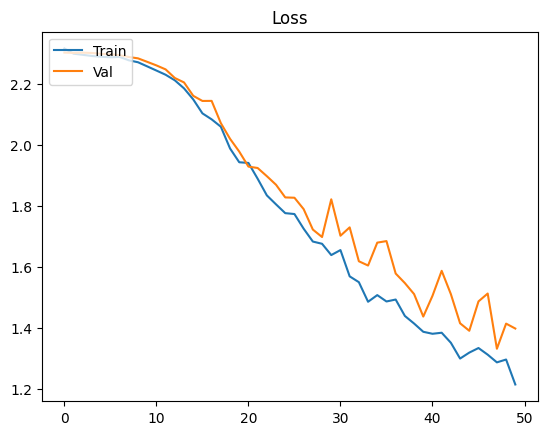

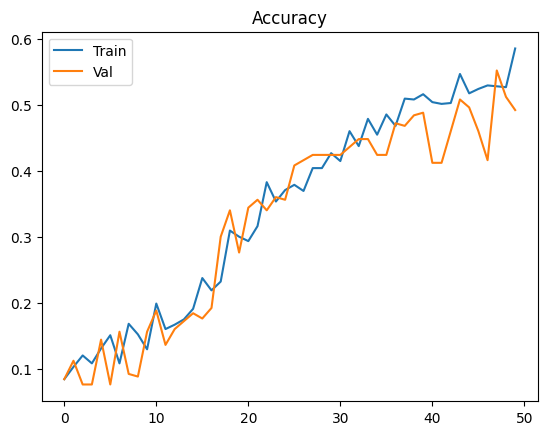

In [15]:
loss_curve = history.history["loss"]
acc_curve = history.history["accuracy"]

loss_val_curve = history.history["val_loss"]
acc_val_curve = history.history["val_accuracy"]

plt.plot(loss_curve, label="Train")
plt.plot(loss_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Loss")
plt.show()

plt.plot(acc_curve, label="Train")
plt.plot(acc_val_curve, label="Val")
plt.legend(loc='upper left')
plt.title("Accuracy")
plt.show()

8/8 [==============================] - 2s 207ms/step


Text(110.44999999999997, 0.5, 'predicted label')

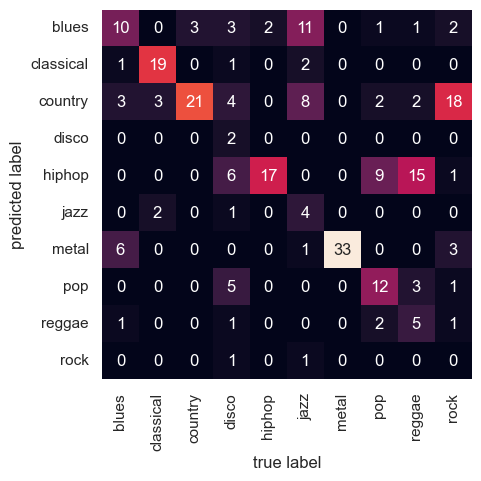

In [16]:
import seaborn as sns
from sklearn.metrics import confusion_matrix # Métriques pour la mesure de performances
sns.set()
predictions = model.predict(x_cnn_test)
mat = confusion_matrix(np.argmax(y_cnn_test, 1), np.argmax(predictions, 1))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=genres, yticklabels=genres)
plt.xlabel('true label')
plt.ylabel('predicted label')

In [17]:
model.save('BadBoyModelV2.keras')

In [18]:
y, sr = librosa.core.load('./Data/genres_original/country/country.00000.wav')

In [19]:
# # y = audio[0]
# # sr = audio[1]

# # Generate log power spectrogram
# S = np.abs(librosa.stft(y))
# spect = librosa.power_to_db(S**2, ref=np.median)

# # Slice to have same shapes for all
# spect = spect[:1000,:1220]

# # Compress for the model
# new_shape = (100,122)
# block_height = spect.shape[0] // new_shape[0]
# block_width = spect.shape[1] // new_shape[1]
# downsampled_array = spect.reshape(new_shape[0], block_height, new_shape[1], block_width).mean(3).mean(1)

# X = np.array([downsampled_array])


mel_specs = []

for g in genres:

  for audio in audio_files[g]:

    # y = audio[0]
    # sr = audio[1]

    spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
    spect = librosa.power_to_db(spect, ref=np.max)
        
# On modifie la taille des images 128 x 660 en gardant les paramètres proposés dans l'article initial
    if spect.shape[1] != 600:
      # spect.resize(128,660, refcheck=False)
      spect = spect[:128,:600]
      # print(spect.shape)
      spect.reshape(128,600)

    mel_specs.append(spect)
        
X = np.array(mel_specs)


In [20]:
# result = model.predict(X, verbose=2)

In [21]:
X.shape

(1000, 128, 600)